In [5]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import xgboost as xgb

In [58]:
companies = ['AAPL']

In [6]:
companies = [
    "AAPL", "MSFT", "GOOGL", "META", "AMZN",  # Technology
    "NVDA", "AMD", "IBM", "INTU", "LRCX", "MU", "ADSK", "PLTR", "ZS", "PANW", "SNOW", "DDOG", "CRWD",  # Semiconductors & Software
    "PYPL", "SQ", "SHOP", "AXP", "GS", "MS", "SPGI", "BLK", "BAC",  # Financials
    "F", "GM", "DE", "RCL", "UAL", "DAL", "AAL", "BKNG", "MAR", "HLT",  # Consumer Discretionary & Travel
    "ABBV", "ABT", "BMY", "LLY", "GILD", "MRNA", "REGN", "TMO", "ISRG", "SYK", "BDX", "DHR",  # Healthcare
    "DIS", "EA", "MO", "CL", "EL", "KHC",  # Consumer Staples & Entertainment
]


In [22]:
companies = [
    "NFLX", "TSLA", "ORCL", "CSCO", "CRM",  # Technology
    "QCOM", "TXN", "ADBE", "SNPS", "AMAT", "NOW", "RNG", "INTC", "HPE",  # Semiconductors & Software
    "V", "MA", "C", "JPM", "WFC", "TROW", "SCHW", "CME", "MSCI",  # Financials
    "NKE", "LULU", "TJX", "COST", "HD", "LOW", "TGT", "WMT", "BBY",  # Consumer Discretionary & Retail
    "JNJ", "PFE", "MRK", "AMGN", "ABBV", "CVS", "GSK", "AZN",  # Healthcare
    "KO", "PEP", "PG", "CLX", "CAG", "SJM", "CPB",  # Consumer Staples
]


In [59]:
data = pd.DataFrame()

In [60]:
for i in companies:
    try:

        curr = yf.download(i, start='2014-10-15', end='2024-10-26')

        curr = curr.reset_index()

        curr.columns = [col[0] for col in curr.columns]

        curr.drop(columns=['Date'], inplace=True)
        empty_data = pd.DataFrame()
        curr = calculate_tech_ind(curr, empty_data)
        data = pd.concat([data, curr], ignore_index=True)

    except Exception as e:
        print(e, i)

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_53696\398422742.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values


In [10]:
def calculate_tech_ind(curr, data):

    data['SMA15'] = ta.sma(curr['Close'], length=15)  # Simple Moving Average
    data['EMA5'] = ta.ema(curr['Close'], length=5)    # Exponential Moving Average
    data['RSI15'] = ta.rsi(curr['Close'], length=15)  # Relative Strength Index

    # Bollinger Bands: Measures volatility with a moving average and standard deviations
    data['BB_upper'], data['BB_lower'] = ta.bbands(curr['Close'], length=56, std=2).iloc[:, [0, 2]].T.values

    # MACD and Signal Line: Trend-following momentum indicator
    data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values

    # On-Balance Volume: Volume-based trend indicator
    data['OBV'] = ta.obv(curr['Close'], curr['Volume'])

    # ADX (Average Directional Index): Measures trend strength
    data['ADX'] = ta.adx(curr['High'], curr['Low'], curr['Close']).iloc[:, 0]

    # Aroon Oscillator: Identifies trend direction and strength
    data['Aroon_Up'], data['Aroon_Down'] = ta.aroon(curr['High'], curr['Low']).iloc[:, [0, 1]].T.values
    
    uncleaned_data = pd.concat([curr, data], axis = 0)

    uncleaned_data = uncleaned_data.iloc[14:, :]

    uncleaned_data.fillna(method='ffill', inplace=True)

    uncleaned_data.fillna(method='bfill', inplace=True)

    scaled_data = scale_data(uncleaned_data)

    return scaled_data

In [9]:
def scale_data(uncscaled_data):
       price_columns = ['Open', 'High', 'Low', 'Close']
       technical_indicators = ['SMA15', 'EMA5',
              'RSI15', 'BB_upper', 'BB_lower', 'MACD', 'MACD_signal', 'OBV', 'ADX',
              'Aroon_Up', 'Aroon_Down']
       volume_column = 'Volume'

       min_max_scaler = MinMaxScaler()
       standard_scaler = StandardScaler()

       uncscaled_data[price_columns] = min_max_scaler.fit_transform(uncscaled_data[price_columns])

       uncscaled_data[volume_column] = np.log1p(uncscaled_data[volume_column])  
       uncscaled_data[[volume_column]] = min_max_scaler.fit_transform(uncscaled_data[[volume_column]])

       uncscaled_data[technical_indicators] = standard_scaler.fit_transform(uncscaled_data[technical_indicators])

       return uncscaled_data



In [61]:
data

,Adj Close,Close,High,Low,Open,Volume,SMA15,EMA5,RSI15,BB_upper,BB_lower,MACD,MACD_signal,OBV,ADX,Aroon_Up,Aroon_Down
0,24.106680,0.021342,0.020762,0.021513,0.022619,0.586846,-0.597943,-0.606053,0.843254,-0.579477,-0.589098,0.181215,-0.173976,-0.649070,0.960341,-0.615450,0.560817
1,24.164387,0.021646,0.020541,0.021996,0.022315,0.555024,-0.597943,-0.606053,0.843254,-0.579477,-0.589098,0.181215,-0.173976,-0.649070,0.960341,-0.615450,0.560817
2,24.233503,0.021459,0.019947,0.021607,0.021731,0.534332,-0.597943,-0.606053,0.843254,-0.579477,-0.589098,0.181215,-0.173976,-0.649070,0.960341,-0.615450,0.560817
3,24.302614,0.021821,0.020564,0.022491,0.021906,0.523042,-0.597943,-0.606053,0.843254,-0.579477,-0.589098,0.181215,-0.173976,-0.649070,0.960341,-0.615450,0.560817
4,24.262487,0.021611,0.020576,0.022633,0.022222,0.458038,-0.597943,-0.606053,0.843254,-0.579477,-0.589098,0.181215,-0.173976,-0.649070,0.960341,-0.615450,0.560817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5031,231.410004,0.976297,0.980100,0.976990,0.968502,0.144990,3.086307,3.138682,-0.390457,3.277075,2.924503,1.220716,1.846432,2.283160,-1.340227,0.265251,-0.114685
5032,231.410004,0.976297,0.980100,0.976990,0.968502,0.144990,3.097964,3.150622,-0.461403,3.276799,2.934459,1.334522,1.812468,2.264000,-1.321177,0.045076,-0.339853
5033,231.410004,0.976297,0.980100,0.976990,0.968502,0.144990,3.102772,3.128147,-0.986872,3.297676,2.930253,1.127015,0.936814,2.238210,-1.346955,-0.175100,-0.565020
5034,231.410004,0.976297,0.980100,0.976990,0.968502,0.144990,3.108691,3.112030,-1.004737,3.325939,2.921060,0.934895,0.276922,2.222865,-1.370893,-0.395275,-0.790188


   Adj Close     Close      High       Low      Open    Volume     SMA15  \
0  24.106680  0.021342  0.020762  0.021513  0.022619  0.586846 -0.597943   
1  24.164387  0.021646  0.020541  0.021996  0.022315  0.555024 -0.597943   
2  24.233503  0.021459  0.019947  0.021607  0.021731  0.534332 -0.597943   
3  24.302614  0.021821  0.020564  0.022491  0.021906  0.523042 -0.597943   
4  24.262487  0.021611  0.020576  0.022633  0.022222  0.458038 -0.597943   

       EMA5     RSI15  BB_upper  BB_lower      MACD  MACD_signal      OBV  \
0 -0.606053  0.843254 -0.579477 -0.589098  0.181215    -0.173976 -0.64907   
1 -0.606053  0.843254 -0.579477 -0.589098  0.181215    -0.173976 -0.64907   
2 -0.606053  0.843254 -0.579477 -0.589098  0.181215    -0.173976 -0.64907   
3 -0.606053  0.843254 -0.579477 -0.589098  0.181215    -0.173976 -0.64907   
4 -0.606053  0.843254 -0.579477 -0.589098  0.181215    -0.173976 -0.64907   

        ADX  Aroon_Up  Aroon_Down       PC1       PC2       PC3  
0  0.960341  -

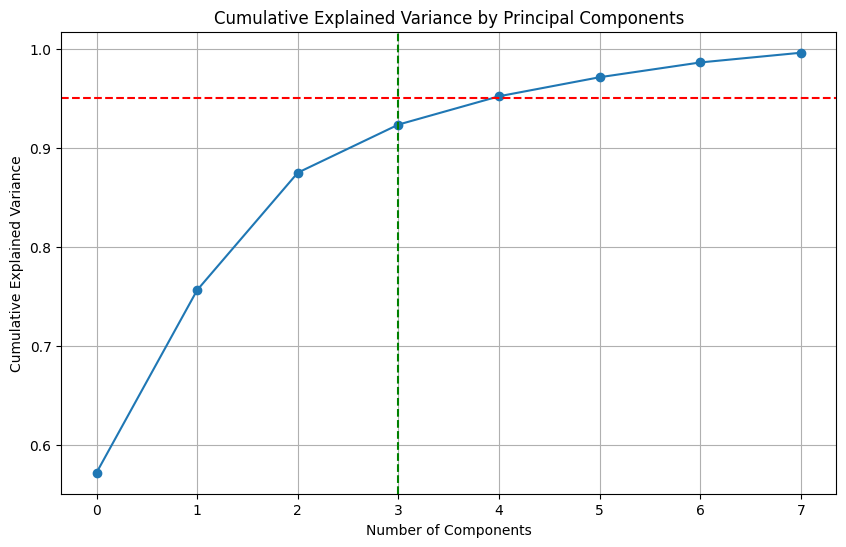

In [62]:
feature_columns = ['Open', 'High', 'Low', 'SMA15', 'EMA5',
       'RSI15', 'BB_upper', 'BB_lower', 'MACD', 'MACD_signal', 'OBV', 'ADX',
       'Aroon_Up', 'Aroon_Down']

X = data[feature_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=8)  
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--') 
plt.axvline(x=np.argmax(cumulative_variance >= 0.90), color='g', linestyle='--') 

n_components_to_keep = np.argmax(cumulative_variance >= 0.90) 
pca_final = PCA(n_components=n_components_to_keep)
X_final = pca_final.fit_transform(X_scaled)

pca_columns = [f'PC{i+1}' for i in range(n_components_to_keep)]
pca_df = pd.DataFrame(data=X_final, columns=pca_columns)

result_df = pd.concat([data.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

print(result_df.head())


In [26]:
pca_df

,PC1,PC2,PC3,PC4
0,-2.992852,0.687571,-1.623401,-0.195766
1,-2.992884,0.687587,-1.623459,-0.195758
2,-2.994173,0.688128,-1.625825,-0.195209
3,-2.992793,0.687551,-1.623288,-0.195803
4,-2.992407,0.687389,-1.622581,-0.195967
...,...,...,...,...
496977,1.453364,-0.125172,-1.358472,1.528616
496978,1.422063,-0.186845,-1.407193,1.362084
496979,1.414246,-0.352019,-1.503956,1.162642
496980,2.123653,-1.456868,-2.051144,0.893074


In [74]:
input = result_df[['PC2', 'PC3']]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(input, data['Close'], test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 0.0019382890082993254
Root Mean Squared Error (RMSE): 0.0440260037738985


In [76]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

R² Score: 0.9872979307469023


In [77]:
model.save_model('regression_model_apple.json') 

In [80]:
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(results.sample())

        Actual  Predicted
4092  0.976297    0.97631


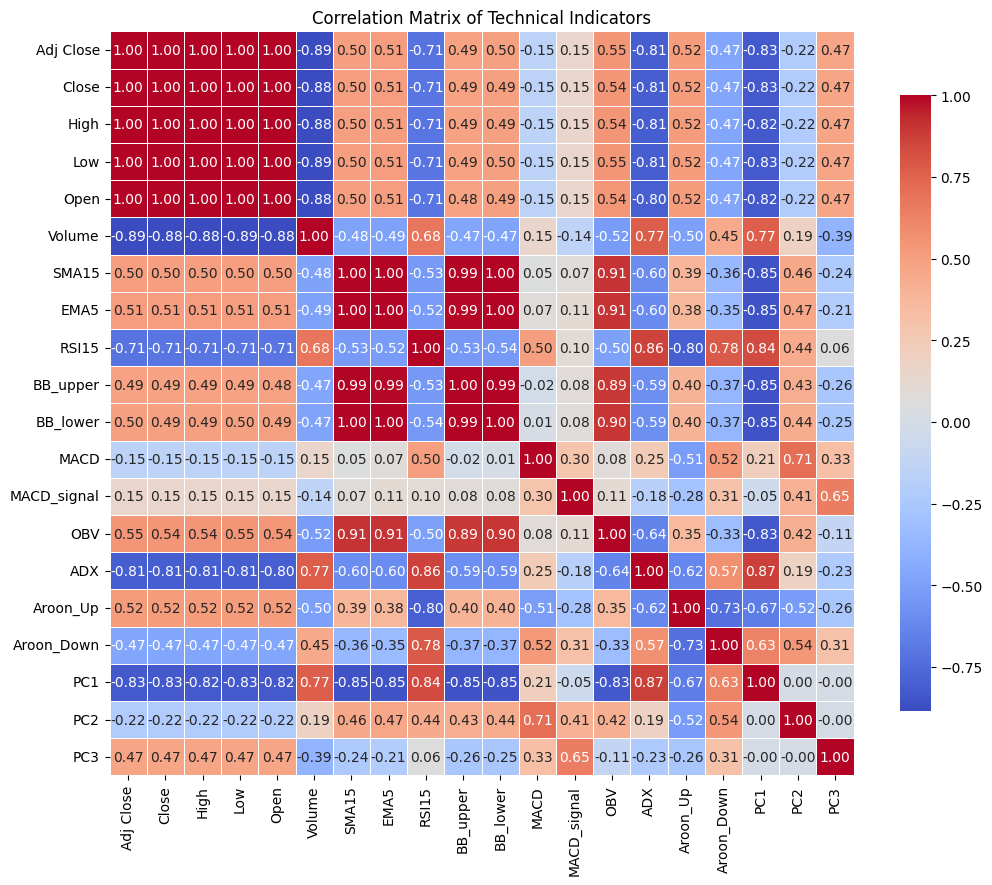

In [63]:


# Calculate the correlation matrix
correlation_matrix = result_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)

# Title and show the plot
plt.title('Correlation Matrix of Technical Indicators')
plt.show()


In [81]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

result_df['Target'] = result_df['Close'].shift(-1) 
result_df.dropna(inplace=True) 

pc_columns = ['PC2', 'PC3']
X = result_df[pc_columns]
y = result_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Build the Neural Network Model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(1)  # Output layer for regression
])

# Step 6: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 7: Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Step 8: Predict on the test set
y_pred = model.predict(X_test_scaled)

# Step 9: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Step 10: Create a DataFrame to compare actual vs predicted prices
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred.flatten()  # Flatten to convert from 2D to 1D
})

# Print the first few rows of the results
print(results.head())


Num GPUs Available:  1


c:\Users\Nishc\anaconda3\envs\TensorFlow_ENV\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/100
101/101 [==============================] - 2s 4ms/step - loss: 0.0861 - val_loss: 0.0416
Epoch 2/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0350 - val_loss: 0.0323
Epoch 3/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0296 - val_loss: 0.0286
Epoch 4/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0261 - val_loss: 0.0239
Epoch 5/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0214 - val_loss: 0.0193
Epoch 6/100
101/101 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0129
Epoch 7/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0112 - val_loss: 0.0094
Epoch 8/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0075
Epoch 9/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 10/100
101/101 [==============================] - 0s 2ms/step - loss: 0.0054 - val_lo

In [45]:
model_dl = model
model_dl.save('dl_model')

INFO:tensorflow:Assets written to: dl_model\assets


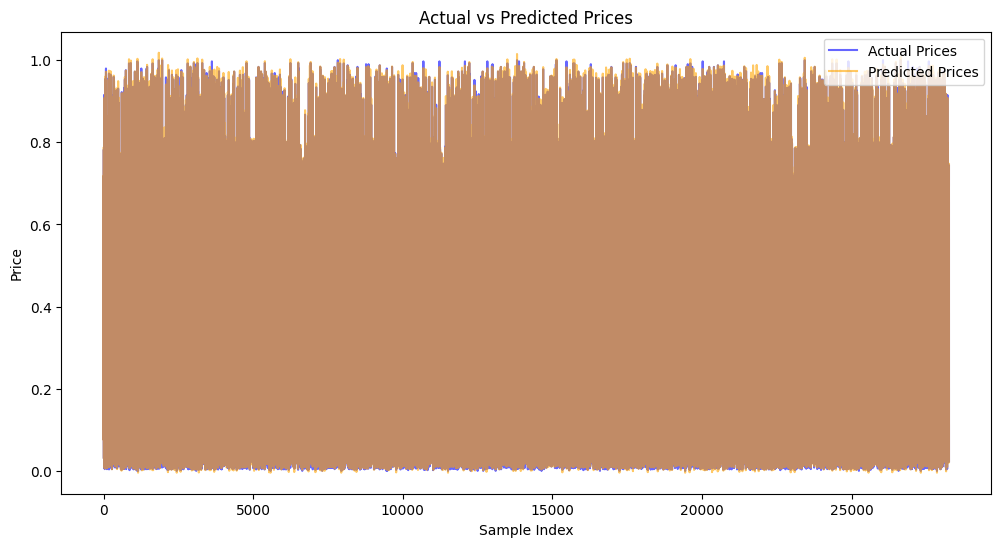

In [32]:

# Plotting actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue', alpha=0.6)
plt.plot(y_pred, label='Predicted Prices', color='orange', alpha=0.6)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()


Linear Regression:
  Mean Squared Error (MSE): 0.0005521771040503732
  Mean Absolute Error (MAE): 0.011183755466732259
  Root Mean Squared Error (RMSE): 0.023498448971163464
  R-squared: 0.9936138632607692



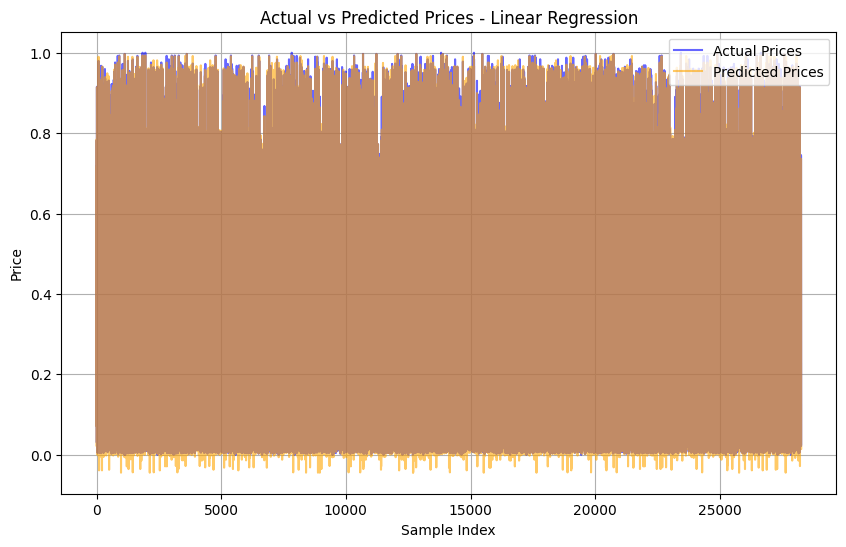

Decision Tree:
  Mean Squared Error (MSE): 2.090416399766373e-06
  Mean Absolute Error (MAE): 5.1219847255641844e-05
  Root Mean Squared Error (RMSE): 0.0014458272371782092
  R-squared: 0.9999758235448863



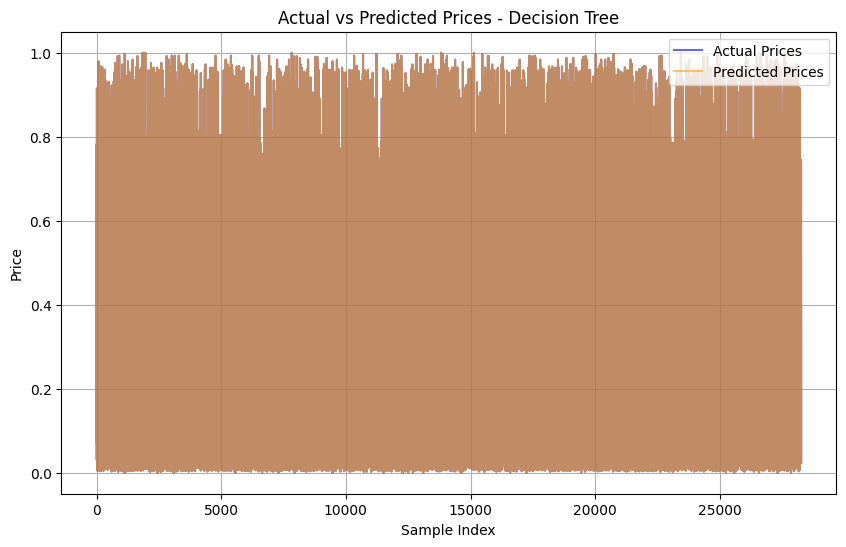

Random Forest:
  Mean Squared Error (MSE): 3.7729359375490554e-06
  Mean Absolute Error (MAE): 7.944971424751456e-05
  Root Mean Squared Error (RMSE): 0.0019424046791410526
  R-squared: 0.9999563645710248



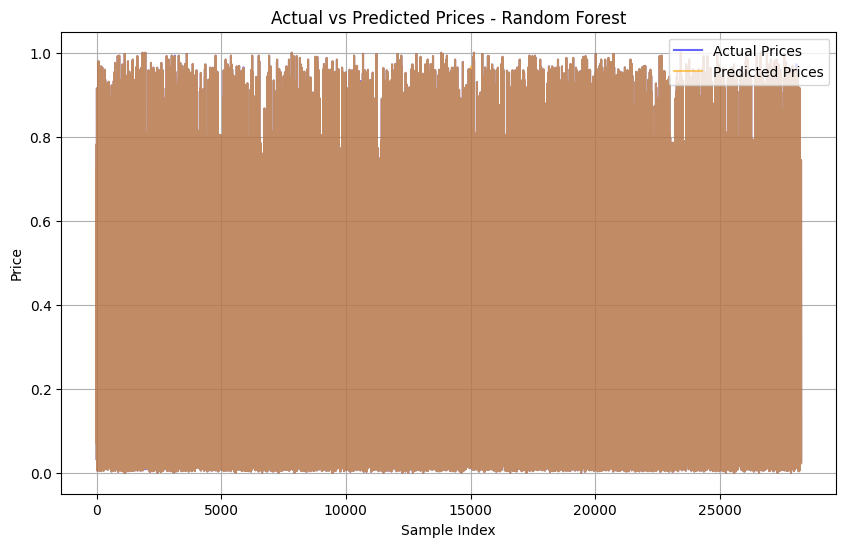

Gradient Boosting:
  Mean Squared Error (MSE): 0.00020924086482088127
  Mean Absolute Error (MAE): 0.00981377209836363
  Root Mean Squared Error (RMSE): 0.014465160380060819
  R-squared: 0.9975800503780773



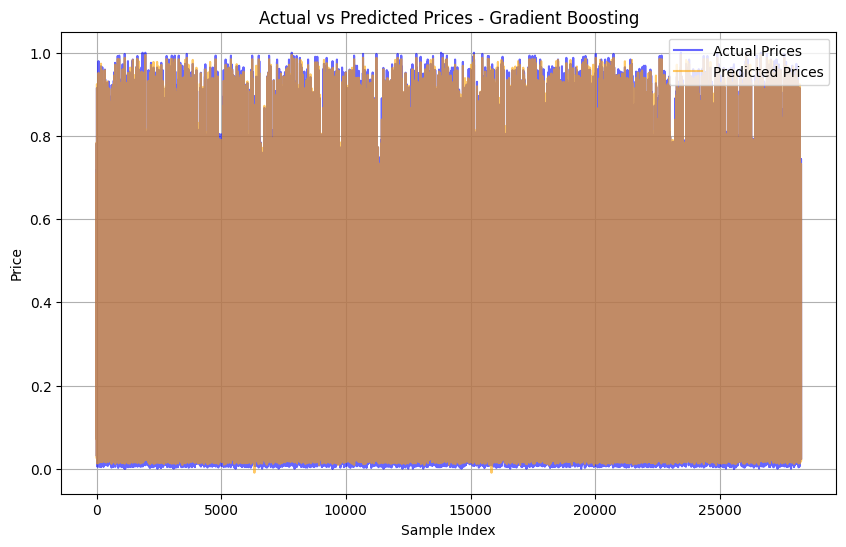

Support Vector Regression:
  Mean Squared Error (MSE): 0.0021723498160389353
  Mean Absolute Error (MAE): 0.037728017300814966
  Root Mean Squared Error (RMSE): 0.0466084736506028
  R-squared: 0.9748759539848615



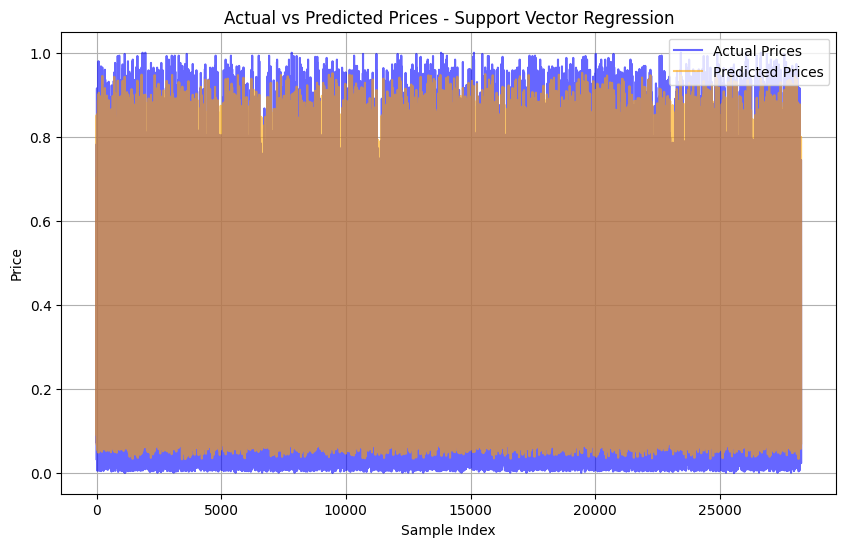

In [33]:
# Create a dictionary of models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR()
}

# Dictionary to store results
results = {}

# Loop through each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, y_pred)

    # Store results
    results[model_name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r_squared,
        'Predictions': y_pred
    }

    # Print metrics
    print(f'{model_name}:')
    print(f'  Mean Squared Error (MSE): {mse}')
    print(f'  Mean Absolute Error (MAE): {mae}')
    print(f'  Root Mean Squared Error (RMSE): {rmse}')
    print(f'  R-squared: {r_squared}')
    print()

    # Plotting Actual vs Predicted Prices
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual Prices', color='blue', alpha=0.6)
    plt.plot(y_pred, label='Predicted Prices', color='orange', alpha=0.6)
    plt.title(f'Actual vs Predicted Prices - {model_name}')
    plt.xlabel('Sample Index')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

# Optionally, if you want to inspect predictions for a specific model:
# print(pd.DataFrame({'Actual': y_test, 'Predicted': results['Random Forest']['Predictions']}))


In [ ]:
X, y

In [22]:
final_X_y = combined_df = pd.concat([X, y], axis=1)  # Use axis=1 to concatenate columns


In [24]:
final_X_y.to_csv('Apple_PreProcessed.csv', index=False)

In [83]:
close = result_df['Close']
print(X.shape)
close.shape

(488, 6)


(488,)

In [86]:
X.drop(columns='Close')

,PC1,PC2,PC3,PC4,PC5,PC6
0,-5.162991,-0.541986,0.220062,2.357983,1.090055,0.380979
1,-5.011012,-0.549788,0.041705,0.720092,1.141468,0.306821
2,-4.892773,-0.498447,0.095553,0.914384,1.002279,0.026247
3,-5.109180,-0.715333,0.030174,0.286908,0.758728,-0.010733
4,-4.668417,-0.011019,0.266225,1.697555,0.806845,-0.693817
...,...,...,...,...,...,...
483,5.152529,-2.638474,-1.411924,-0.713939,0.876088,-0.977746
484,5.274330,-2.607776,-1.534213,-1.258563,0.711122,-1.124922
485,5.281182,-2.233062,-1.712728,-0.845524,0.816643,-0.523317
486,5.387174,-1.909324,-1.667759,-0.162987,0.603943,-0.871710


In [87]:
X_new = pd.concat([X,close], axis=1)

In [ ]:


# Assuming 'data' is your original DataFrame containing the feature columns

# Step 1: Fit PCA
pca = PCA(n_components=6)
pca.fit(data)

# Step 2: Transform the data
X = pca.transform(data)

# Step 3: Retrieve component loadings
loadings = pd.DataFrame(pca.components_.T, index=data.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
print("Component Loadings:")
print(loadings)

# Step 4: Explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance by Each Component:", explained_variance)

# Step 5: Visualize the first two principal components with a biplot
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)

# Add arrows for feature contributions
for i, feature in enumerate(data.columns):
    plt.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], 
              color='r', alpha=0.5, head_width=0.05)
    plt.text(loadings.iloc[i, 0], loadings.iloc[i, 1], feature, 
             color='black', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of PCA')
plt.grid()
plt.axhline(0, color='black', linewidth=0.5, ls='--')
plt.axvline(0, color='black', linewidth=0.5, ls='--')
plt.show()


In [88]:


def create_labels(data, label_type, threshold=None):
    """
    Create labels for different classification types.
    
    Args:
    - data: DataFrame containing the features.
    - label_type: Type of classification ('binary', 'multiclass', 'conditional').
    - threshold: Threshold for binary classification (for 'binary' and 'multi-class').
    
    Returns:
    - labels: Series of labels.
    """
    # Example target column: 'Close'
    target_column = 'Close'
    
    # Ensure the target column exists in the DataFrame
    if target_column not in data.columns:
        raise ValueError(f"{target_column} not found in DataFrame.")
    
    if label_type == 'binary':
        if threshold is None:
            threshold = data[target_column].median()  # Default threshold to median
        labels = (data[target_column] > threshold).astype(int)  # 1 if above threshold, else 0
    
    elif label_type == 'multiclass':
        bins = [0, 100, 150, 200, np.inf]  # Define your bins
        labels = pd.cut(data[target_column], bins=bins, labels=[0, 1, 2, 3], right=False)
    
    elif label_type == 'conditional':
        labels = np.where(data[target_column] > data[target_column].mean(), 1, 0)  # 1 if above average, else 0
    
    else:
        raise ValueError("Invalid label_type. Choose 'binary', 'multiclass', or 'conditional'.")
    
    return labels


In [90]:
labels = create_labels(X, "binary")

0      0
1      0
2      0
3      0
4      0
      ..
483    1
484    1
485    1
486    1
487    1
Name: Close, Length: 488, dtype: int32

In [99]:


def classify_and_evaluate(data, label_type, threshold=None):
    """
    Classify and evaluate the model performance on various algorithms.
    
    Args:
    - data: DataFrame containing the features and target.
    - label_type: Type of classification ('binary', 'multiclass', 'conditional').
    - threshold: Threshold for binary classification.
    
    Returns:
    - None (prints model evaluations).
    """
    # Create labels
    labels = create_labels(data, label_type, threshold)
    
    # Define features (excluding target)
    feature_columns = [col for col in data.columns if col != 'Close']  # Adjust as needed
    X = data[feature_columns]
    y = labels
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    y_train = y_train.iloc[:,0]
    y_test = y_test.iloc[:,0]
    # Initialize classifiers
    classifiers = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=200),
        'Support Vector Classifier': SVC(),
        'K-Nearest Neighbors': KNeighborsClassifier()
    }
    
    # Evaluate each classifier
    for name, clf in classifiers.items():
        print(X_train.head())
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        print(f"{name} Accuracy: {accuracy:.4f}")
        print(report)

classify_and_evaluate(X_new, label_type='binary', threshold=150)  # Adjust threshold as needed


          PC1       PC2       PC3       PC4       PC5       PC6
415  4.525141  1.789435  1.421528 -0.646582  0.796932  0.808185
314  0.814330 -1.617865 -0.539504  0.014556  0.266293 -0.090640
25  -4.701296 -1.100486 -0.380481  0.119212  1.045310 -0.977684
222 -1.030559 -2.669881  0.105975  0.308785 -0.169799  0.080492
298  0.017101 -2.350513  0.340390  0.258032 -0.705902 -0.465540
Random Forest Accuracy: 0.9082
              precision    recall  f1-score   support

           0       0.90      0.53      0.67        17
           1       0.91      0.99      0.95        81

    accuracy                           0.91        98
   macro avg       0.90      0.76      0.81        98
weighted avg       0.91      0.91      0.90        98

          PC1       PC2       PC3       PC4       PC5       PC6
415  4.525141  1.789435  1.421528 -0.646582  0.796932  0.808185
314  0.814330 -1.617865 -0.539504  0.014556  0.266293 -0.090640
25  -4.701296 -1.100486 -0.380481  0.119212  1.045310 -0.977684
22

In [93]:
y.shape


(488,)